### Dataset loader for the deep learning model training.

In [1]:
import time
import torch 
import random 
import numpy as np 
from glob import glob 
import rasterio as rio 
from notebooks import config 
from utils.imgShow import imsShow  
from utils.img2patch import crop2patch
from utils.dataloader import SceneArraySet_scales, PatchPathSet_scales


In [2]:
patch_size = 256
higher_patch_size = 1024


In [3]:
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
# paths_dem_tra = config.paths_dem_adjust_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{higher_patch_size}/*'))  ## for model prediction 
# paths_patch_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}_dem_adjust/*'))
print(f'vali patch: {len(paths_valset)}')


train scenes: 48
vali patch: 293


In [4]:
def read_scenes(scene_paths, truth_paths, dem_paths):
    paths_zip = zip(scene_paths, truth_paths, dem_paths)
    scenes_arr = []
    truths_arr = []
    for scene_path, truth_path, dem_path in paths_zip:
        ## 1. read scene and truth images
        with rio.open(scene_path) as src:
            scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)
        with rio.open(truth_path) as truth_src:
            truth_arr = truth_src.read(1)  # (H, W)
        ## 2. read dem
        with rio.open(dem_path) as dem_src:
            dem_arr = dem_src.read(1)  # (H, W)
        dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
        scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1)  # (H, W, C+1)
        scenes_arr.append(scene_arr)
        truths_arr.append(truth_arr)
    return scenes_arr, truths_arr
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra)


In [5]:
## load traset
scenes_dem_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra)
print('traset:', len(scenes_dem_arr))


traset: 48


In [6]:
# Create dataset instances
tra_data = SceneArraySet_scales(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         patch_size=256, 
                         higher_patch_size=1024,
                         patch_resize=False) 
val_data = PatchPathSet_scales(paths_valset=paths_valset,  
                        higher_patch_size=1024,
                        patch_size=256,
                        patch_resize=False)  


(256, 256, 7) torch.Size([1, 256, 256])
training data size: 48
validation data size: 293


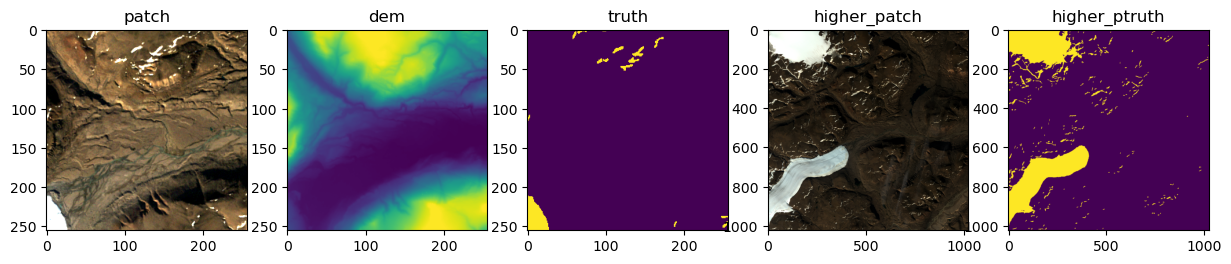

In [12]:
patch_pdem, ptruth, higher_patch_pdem, higher_patch_truth = tra_data[0]
patch_pdem = patch_pdem.numpy().astype(float).transpose((1, 2, 0))
higher_patch_pdem = higher_patch_pdem.numpy().astype(float).transpose((1, 2, 0))
patch, dem = patch_pdem[...,:-1], patch_pdem[...,-1]  # last channel is dem
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([patch, dem, ptruth[0].numpy(), higher_patch_pdem, higher_patch_truth.numpy()], 
            clip_list=[2,2,2,2,2], 
            img_name_list=['patch','dem','truth','higher_patch', 'higher_ptruth'], 
            figsize=(15, 3))


(256, 256, 7) torch.Size([1, 256, 256])
training data size: 48
validation data size: 293


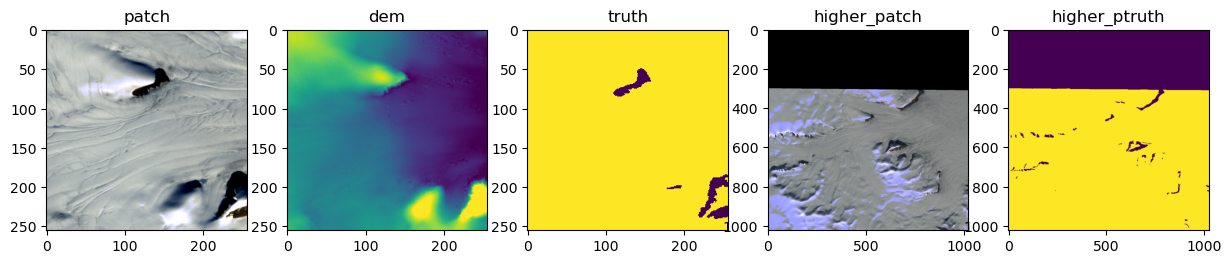

In [8]:
patch_pdem, ptruth, higher_patch_pdem, higher_patch_truth = val_data[11]
patch_pdem = patch_pdem.numpy().astype(float).transpose((1, 2, 0))
higher_patch_pdem = higher_patch_pdem.numpy().astype(float).transpose((1, 2, 0))
patch, dem = patch_pdem[...,:-1], patch_pdem[...,-1]  # last channel is dem
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([patch, dem, ptruth[0].numpy(), higher_patch_pdem, higher_patch_truth.numpy()], 
            clip_list=[2,2,2,2,2], 
            img_name_list=['patch','dem','truth','higher_patch', 'higher_ptruth'], figsize=(15, 3))


In [9]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4,
                                         num_workers=10)


In [10]:
# check data loading time
time_start = time.time()
for x_patch, y_patch, x_scene, y_scene in tra_loader:
  print(f"traBatch processing time: {time.time() - time_start:.1f}")
time_start = time.time()  

# ## check data loading time
# time_start = time.time()
# for x_patch, y_patch, x_scene, y_scene in val_loader:
#   print(f"valBatch processing time: {time.time() - time_start:.1f}")
# time_start = time.time()   


traBatch processing time: 1.2
traBatch processing time: 1.8
traBatch processing time: 1.8
traBatch processing time: 1.8
traBatch processing time: 1.8
traBatch processing time: 1.8
traBatch processing time: 1.8
traBatch processing time: 1.8
traBatch processing time: 1.9
traBatch processing time: 1.9
traBatch processing time: 1.9
traBatch processing time: 2.4


torch.Size([4, 7, 256, 256]) torch.Size([4, 1, 256, 256])


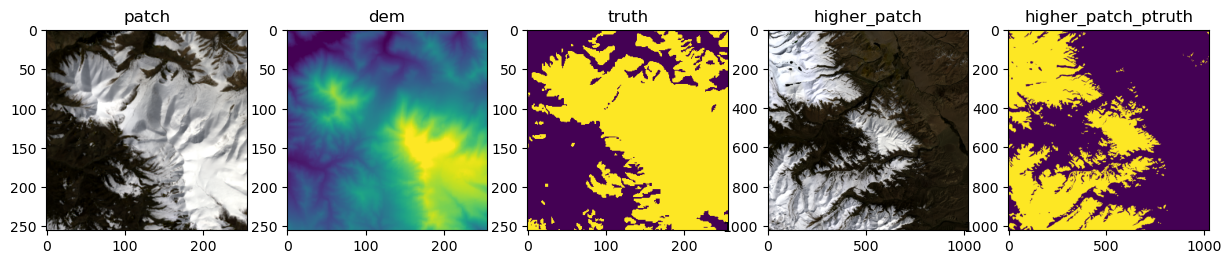

In [11]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_ptruth, batch_scene, batch_scene_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_ptruth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
pdem_arr = batch_patch[0].numpy()[-1]
ptruth_arr = batch_ptruth[0].numpy().squeeze()
scene_arr = batch_scene[0].numpy().transpose((1, 2, 0))
scene_truth_arr = batch_scene_truth[0].numpy().squeeze()
imsShow([patch_arr, pdem_arr, ptruth_arr, scene_arr, scene_truth_arr],  
          color_bands_list=[[2,1,0], None, None, [2,1,0], None],
          img_name_list=['patch', 'dem', 'truth', 'higher_patch', 'higher_patch_ptruth'], 
          clip_list=[2,2,2,2,2], 
          figsize=(15, 3))
